Import Required Libraries

In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

import The Dataset Which is required for model training

In [61]:
data_train = pd.read_excel("Data_Train.xlsx")
data_train.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302


Check whether any null values are there or not. if present following can be done:
1. Impute data using imputation method
2. Filling NAN valus with mean median or mode using fillna() method

In [62]:
#check for null values
data_train.isna().sum()

Airline            0
Date_of_Journey    0
Source             0
Destination        0
Route              1
Dep_Time           0
Arrival_Time       0
Duration           0
Total_Stops        1
Additional_Info    0
Price              0
dtype: int64

In [63]:
# Drop null values
data_train.dropna(inplace=True)
data_train.isna().sum()

Airline            0
Date_of_Journey    0
Source             0
Destination        0
Route              0
Dep_Time           0
Arrival_Time       0
Duration           0
Total_Stops        0
Additional_Info    0
Price              0
dtype: int64

In [64]:
# Decsribe dataset to see statistical details
data_train.describe()

,Price
count,10682.000000
mean,9087.214567
std,4611.548810
min,1759.000000
25%,5277.000000
50%,8372.000000
75%,12373.000000
max,79512.000000


In [65]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10682 entries, 0 to 10682
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Airline          10682 non-null  object
 1   Date_of_Journey  10682 non-null  object
 2   Source           10682 non-null  object
 3   Destination      10682 non-null  object
 4   Route            10682 non-null  object
 5   Dep_Time         10682 non-null  object
 6   Arrival_Time     10682 non-null  object
 7   Duration         10682 non-null  object
 8   Total_Stops      10682 non-null  object
 9   Additional_Info  10682 non-null  object
 10  Price            10682 non-null  int64 
dtypes: int64(1), object(10)
memory usage: 1001.4+ KB


# EDA

From description we casn see that Date_of_Journey is a object data type.
Therefore we have to convet this datatype into timestamp sop as to use this column properly for prediction
For this we require pandas to_datetime() method

.dt.day -> extract only day of that date
.dt.month -> extract only month of that date
.dt.year -> extrcat only yewr of that date

In [66]:
data_train["Journey_day"] =pd.to_datetime(data_train.Date_of_Journey, format="%d/%m/%Y").dt.day
data_train["Journey_month"] =pd.to_datetime(data_train.Date_of_Journey, format="%d/%m/%Y").dt.month
data_train.head(2)

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price,Journey_day,Journey_month
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897,24,3
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662,1,5


In [67]:
# Now there is no use od Date_of_Journey so drop it
data_train.drop(["Date_of_Journey"],axis=1,inplace=True)
data_train.head(1)

,Airline,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price,Journey_day,Journey_month
0,IndiGo,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897,24,3


In [68]:
# do the same thing fo Dep and Arrival Time
# Extract hours from dep time
data_train["Dep_hour"]= pd.to_datetime(data_train["Dep_Time"]).dt.hour
# Extract mins from dep time
data_train["Dep_min"]= pd.to_datetime(data_train["Dep_Time"]).dt.minute
# drop Dep_Time
data_train.drop(["Dep_Time"],axis=1,inplace=True)
# Extract hours from Arrival time
data_train["Arrival_hour"]= pd.to_datetime(data_train["Arrival_Time"]).dt.hour
# Extract mins from Arrival_Time
data_train["Arrival_min"]= pd.to_datetime(data_train["Arrival_Time"]).dt.minute
# drop Arrival_Time
data_train.drop(["Arrival_Time"],axis=1,inplace=True)
data_train.head(1)

,Airline,Source,Destination,Route,Duration,Total_Stops,Additional_Info,Price,Journey_day,Journey_month,Dep_hour,Dep_min,Arrival_hour,Arrival_min
0,IndiGo,Banglore,New Delhi,BLR → DEL,2h 50m,non-stop,No info,3897,24,3,22,20,1,10


In [69]:
# DO same thing for duration 
duration = list(data_train["Duration"])
for i in range(len(duration)):
    if len(duration[i].split()) != 2: # Check if duration contains only nhour or mins
        if 'h' in duration[i]:
            duration[i]=  duration[i].strip() + " 0m" #Adds 0 minutes
        else:
            duration[i] = "0h "+duration[i] # Adds 0 hour
duration_hours = []
duration_mins = []
for i in range(len(duration)):
    duration_hours.append(int(duration[i].split(sep= "h")[0]))
    duration_mins.append(int(duration[i].split(sep= "m")[0].split()[-1]))
data_train["Duration_hour"]=duration_hours 
data_train["Duration_mins"]=duration_mins
data_train.drop(["Duration"],axis=1,inplace=True)
          
        

In [70]:
data_train.head(2)  

,Airline,Source,Destination,Route,Total_Stops,Additional_Info,Price,Journey_day,Journey_month,Dep_hour,Dep_min,Arrival_hour,Arrival_min,Duration_hour,Duration_mins
0,IndiGo,Banglore,New Delhi,BLR → DEL,non-stop,No info,3897,24,3,22,20,1,10,2,50
1,Air India,Kolkata,Banglore,CCU → IXR → BBI → BLR,2 stops,No info,7662,1,5,5,50,13,15,7,25


# Handling Categorical data

We can handle categorical data using two method
1. OneHotEncoding
2. LabelEncoder

In [71]:
data_train["Airline"].value_counts()

Jet Airways                          3849
IndiGo                               2053
Air India                            1751
Multiple carriers                    1196
SpiceJet                              818
Vistara                               479
Air Asia                              319
GoAir                                 194
Multiple carriers Premium economy      13
Jet Airways Business                    6
Vistara Premium economy                 3
Trujet                                  1
Name: Airline, dtype: int64

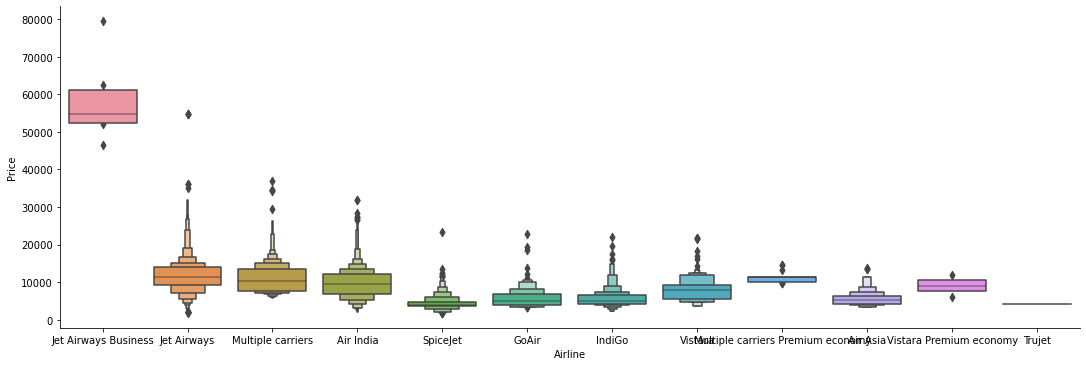

In [72]:
#Plot a catplot to see relation between columns
sns.catplot(y="Price",x="Airline",data=data_train.sort_values("Price",ascending=False),kind="boxen",height=5,aspect=3)
plt.show()

In [73]:
# Apply OneHotEncoding on Airline
Airline= data_train[["Airline"]]
Airline= pd.get_dummies(Airline,drop_first=True)
Airline

,Airline_Air India,Airline_GoAir,Airline_IndiGo,Airline_Jet Airways,Airline_Jet Airways Business,Airline_Multiple carriers,Airline_Multiple carriers Premium economy,Airline_SpiceJet,Airline_Trujet,Airline_Vistara,Airline_Vistara Premium economy
0,0,0,1,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0
2,0,0,0,1,0,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
10678,0,0,0,0,0,0,0,0,0,0,0
10679,1,0,0,0,0,0,0,0,0,0,0
10680,0,0,0,1,0,0,0,0,0,0,0
10681,0,0,0,0,0,0,0,0,0,1,0


In [74]:
data_train["Source"].head(2)

0    Banglore
1     Kolkata
Name: Source, dtype: object

In [75]:
#Apply Same for it as Airline
source = data_train[["Source"]]
Source= pd.get_dummies(source,drop_first=True)
Source.head(2)

,Source_Chennai,Source_Delhi,Source_Kolkata,Source_Mumbai
0,0,0,0,0
1,0,0,1,0


In [76]:
#Apply Same for Destination as Airline
Destination = data_train[["Destination"]]
Destination= pd.get_dummies(Destination,drop_first=True)
Destination.head(2)

,Destination_Cochin,Destination_Delhi,Destination_Hyderabad,Destination_Kolkata,Destination_New Delhi
0,0,0,0,0,1
1,0,0,0,0,0


In [77]:
#Apply Same for Route as Airline
Route = data_train[["Route"]]
Route = pd.get_dummies(Route,drop_first=True)
Route.head(2)

,Route_BLR → BBI → DEL,Route_BLR → BDQ → DEL,Route_BLR → BOM → AMD → DEL,Route_BLR → BOM → BHO → DEL,Route_BLR → BOM → DEL,Route_BLR → BOM → IDR → DEL,Route_BLR → BOM → IDR → GWL → DEL,Route_BLR → BOM → IXC → DEL,Route_BLR → BOM → JDH → DEL,Route_BLR → BOM → NAG → DEL,...,Route_DEL → LKO → BOM → COK,Route_DEL → LKO → COK,Route_DEL → MAA → BOM → COK,Route_DEL → MAA → COK,Route_DEL → NAG → BOM → COK,Route_DEL → PNQ → COK,Route_DEL → RPR → NAG → BOM → COK,Route_DEL → TRV → COK,Route_DEL → UDR → BOM → COK,Route_MAA → CCU
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [78]:
data_train["Total_Stops"].head(5)

0    non-stop
1     2 stops
2     2 stops
3      1 stop
4      1 stop
Name: Total_Stops, dtype: object

In [79]:
# change Non Stop - 0, 1 stop - 1, 2 stop-2, 3 stop -3 , 4 stop-4
data_train.replace({"non-stop": 0,"1 stop":1,"2 stops":2,"3 stops":3,"4 stops":4},inplace=True)
data_train.head()

,Airline,Source,Destination,Route,Total_Stops,Additional_Info,Price,Journey_day,Journey_month,Dep_hour,Dep_min,Arrival_hour,Arrival_min,Duration_hour,Duration_mins
0,IndiGo,Banglore,New Delhi,BLR → DEL,0,No info,3897,24,3,22,20,1,10,2,50
1,Air India,Kolkata,Banglore,CCU → IXR → BBI → BLR,2,No info,7662,1,5,5,50,13,15,7,25
2,Jet Airways,Delhi,Cochin,DEL → LKO → BOM → COK,2,No info,13882,9,6,9,25,4,25,19,0
3,IndiGo,Kolkata,Banglore,CCU → NAG → BLR,1,No info,6218,12,5,18,5,23,30,5,25
4,IndiGo,Banglore,New Delhi,BLR → NAG → DEL,1,No info,13302,1,3,16,50,21,35,4,45


In [80]:
# drop airline destination route source
data_train.drop(["Airline","Source","Destination","Route","Additional_Info"],axis=1,inplace=True)

In [81]:
# Now add preprocessd data

In [82]:
train_data = pd.concat([data_train,Airline,Route,Source,Destination],axis=1)
train_data.head(2)

,Total_Stops,Price,Journey_day,Journey_month,Dep_hour,Dep_min,Arrival_hour,Arrival_min,Duration_hour,Duration_mins,...,Route_MAA → CCU,Source_Chennai,Source_Delhi,Source_Kolkata,Source_Mumbai,Destination_Cochin,Destination_Delhi,Destination_Hyderabad,Destination_Kolkata,Destination_New Delhi
0,0,3897,24,3,22,20,1,10,2,50,...,0,0,0,0,0,0,0,0,0,1
1,2,7662,1,5,5,50,13,15,7,25,...,0,0,0,1,0,0,0,0,0,0


In [83]:
train_data.shape

(10682, 157)

# Test Data

In [84]:
test_data = pd.read_excel(r"C:/Users/acer/OneDrive/Desktop/Learning-Program/Learning-Program/flight-fare-prediction-rahuljha/Test_set.xlsx")
test_data.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info
0,Jet Airways,6/06/2019,Delhi,Cochin,DEL → BOM → COK,17:30,04:25 07 Jun,10h 55m,1 stop,No info
1,IndiGo,12/05/2019,Kolkata,Banglore,CCU → MAA → BLR,06:20,10:20,4h,1 stop,No info
2,Jet Airways,21/05/2019,Delhi,Cochin,DEL → BOM → COK,19:15,19:00 22 May,23h 45m,1 stop,In-flight meal not included
3,Multiple carriers,21/05/2019,Delhi,Cochin,DEL → BOM → COK,08:00,21:00,13h,1 stop,No info
4,Air Asia,24/06/2019,Banglore,Delhi,BLR → DEL,23:55,02:45 25 Jun,2h 50m,non-stop,No info


In [85]:
# do the same preprocessing as done for train data
# Drop null values
test_data.dropna(inplace=True)
test_data.isna().sum()
# Decsribe dataset to see statistical details
test_data.describe()
test_data["Journey_day"] =pd.to_datetime(test_data.Date_of_Journey, format="%d/%m/%Y").dt.day
test_data["Journey_month"] =pd.to_datetime(test_data.Date_of_Journey, format="%d/%m/%Y").dt.month
# Now there is no use od Date_of_Journey so drop it
test_data.drop(["Date_of_Journey"],axis=1,inplace=True)
# do the same thing fo Dep and Arrival Time
# Extract hours from dep time
test_data["Dep_hour"]= pd.to_datetime(test_data["Dep_Time"]).dt.hour
# Extract mins from dep time
test_data["Dep_min"]= pd.to_datetime(test_data["Dep_Time"]).dt.minute
# drop Dep_Time
test_data.drop(["Dep_Time"],axis=1,inplace=True)
# Extract hours from Arrival time
test_data["Arrival_hour"]= pd.to_datetime(test_data["Arrival_Time"]).dt.hour
# Extract mins from Arrival_Time
test_data["Arrival_min"]= pd.to_datetime(test_data["Arrival_Time"]).dt.minute
# drop Arrival_Time
test_data.drop(["Arrival_Time"],axis=1,inplace=True)
# DO same thing for duration 
duration = list(test_data["Duration"])
for i in range(len(duration)):
    if len(duration[i].split()) != 2: # Check if duration contains only nhour or mins
        if 'h' in duration[i]:
            duration[i]=  duration[i].strip() + " 0m" #Adds 0 minutes
        else:
            duration[i] = "0h "+duration[i] # Adds 0 hour
duration_hours = []
duration_mins = []
for i in range(len(duration)):
    duration_hours.append(int(duration[i].split(sep= "h")[0]))
    duration_mins.append(int(duration[i].split(sep= "m")[0].split()[-1]))
test_data["Duration_hour"]=duration_hours 
test_data["Duration_mins"]=duration_mins
test_data.drop(["Duration"],axis=1,inplace=True)
# Apply OneHotEncoding on Airline
Airline= test_data[["Airline"]]
Airline= pd.get_dummies(Airline,drop_first=True)
Airline.head(2)
#Apply Same for Route as Airline
Route = test_data[["Route"]]
Route = pd.get_dummies(Route,drop_first=True)
Route.head(2)
#Apply Same for it as Airline
source = test_data[["Source"]]
Source= pd.get_dummies(source,drop_first=True)
Source.head(2)
#Apply Same for Destination as Airline
Destination = test_data[["Destination"]]
Destination= pd.get_dummies(Destination,drop_first=True)
Destination.head(2)
#Apply Same for Route as Airline
Route = test_data[["Route"]]
Route = pd.get_dummies(Route,drop_first=True)
Route.head(2)
# change Non Stop - 0, 1 stop - 1, 2 stop-2, 3 stop -3 , 4 stop-4
test_data.replace({"non-stop": 0,"1 stop":1,"2 stops":2,"3 stops":3,"4 stops":4},inplace=True)
test_data.head()
# drop airline destination route source
test_data.drop(["Airline","Source","Destination","Route","Additional_Info"],axis=1,inplace=True)
data_test = pd.concat([test_data,Airline,Route,Source,Destination],axis=1)
data_test.head(2)
#data_test.shape

,Total_Stops,Journey_day,Journey_month,Dep_hour,Dep_min,Arrival_hour,Arrival_min,Duration_hour,Duration_mins,Airline_Air India,...,Route_MAA → CCU,Source_Chennai,Source_Delhi,Source_Kolkata,Source_Mumbai,Destination_Cochin,Destination_Delhi,Destination_Hyderabad,Destination_Kolkata,Destination_New Delhi
0,1,6,6,17,30,4,25,10,55,0,...,0,0,1,0,0,1,0,0,0,0
1,1,12,5,6,20,10,20,4,0,0,...,0,0,0,1,0,0,0,0,0,0


In [86]:
data_test.columns

Index(['Total_Stops', 'Journey_day', 'Journey_month', 'Dep_hour', 'Dep_min',
       'Arrival_hour', 'Arrival_min', 'Duration_hour', 'Duration_mins',
       'Airline_Air India',
       ...
       'Route_MAA → CCU', 'Source_Chennai', 'Source_Delhi', 'Source_Kolkata',
       'Source_Mumbai', 'Destination_Cochin', 'Destination_Delhi',
       'Destination_Hyderabad', 'Destination_Kolkata',
       'Destination_New Delhi'],
      dtype='object', length=127)

# Feature Selection 

Methods to show correleted data
1.heatmap
2. SelectKBest

In [87]:
y = train_data["Price"]
y.head()

0     3897
1     7662
2    13882
3     6218
4    13302
Name: Price, dtype: int64

In [88]:
#plt.figure(figsize=(18,18))
#sns.heatmap(train_data.corr(),annot=True,cmap="RdYlGn")
#plt.show()

In [89]:
train_data.drop(["Price"],axis=1,inplace=True)
X =train_data

In [90]:
X.head()

,Total_Stops,Journey_day,Journey_month,Dep_hour,Dep_min,Arrival_hour,Arrival_min,Duration_hour,Duration_mins,Airline_Air India,...,Route_MAA → CCU,Source_Chennai,Source_Delhi,Source_Kolkata,Source_Mumbai,Destination_Cochin,Destination_Delhi,Destination_Hyderabad,Destination_Kolkata,Destination_New Delhi
0,0,24,3,22,20,1,10,2,50,0,...,0,0,0,0,0,0,0,0,0,1
1,2,1,5,5,50,13,15,7,25,1,...,0,0,0,1,0,0,0,0,0,0
2,2,9,6,9,25,4,25,19,0,0,...,0,0,1,0,0,1,0,0,0,0
3,1,12,5,18,5,23,30,5,25,0,...,0,0,0,1,0,0,0,0,0,0
4,1,1,3,16,50,21,35,4,45,0,...,0,0,0,0,0,0,0,0,0,1


In [91]:
# Extract important feature using ExtraTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor
selection = ExtraTreesRegressor()
selection.fit(X,y)

ExtraTreesRegressor()

In [92]:
print(selection.feature_importances_)

[2.15856163e-01 1.42261709e-01 5.36151403e-02 1.66975163e-02
 1.44482570e-02 2.03696580e-02 1.09856323e-02 1.24639422e-01
 1.04356062e-02 9.29922667e-03 1.97033475e-03 1.81351292e-02
 1.37825549e-01 6.48653646e-02 1.42830539e-02 3.71377817e-04
 2.82343215e-03 3.67075321e-05 4.41812559e-03 8.92675038e-05
 1.60984381e-05 2.72440383e-04 6.54133068e-05 1.39218707e-03
 1.74881652e-02 1.60749804e-04 5.91529083e-06 7.82294379e-07
 4.23077507e-05 7.35626539e-04 1.54375349e-05 2.53653780e-04
 3.18031278e-05 4.21517467e-05 4.36168721e-05 5.95276772e-05
 1.41304320e-04 1.18934913e-02 8.69084026e-05 1.97448191e-05
 1.46342714e-05 8.91595522e-06 2.10024577e-06 1.77208495e-03
 1.33817701e-04 4.48383726e-05 1.45343447e-05 6.10967008e-04
 1.10939757e-04 2.34982348e-04 1.99406584e-05 3.36823536e-06
 6.08294674e-05 1.12053881e-04 6.65946723e-05 2.17855386e-05
 2.38727992e-05 4.22067441e-06 1.86834613e-05 3.53088070e-06
 6.86558377e-05 8.90381984e-05 2.24926116e-05 3.32445744e-07
 2.63101424e-04 3.500731

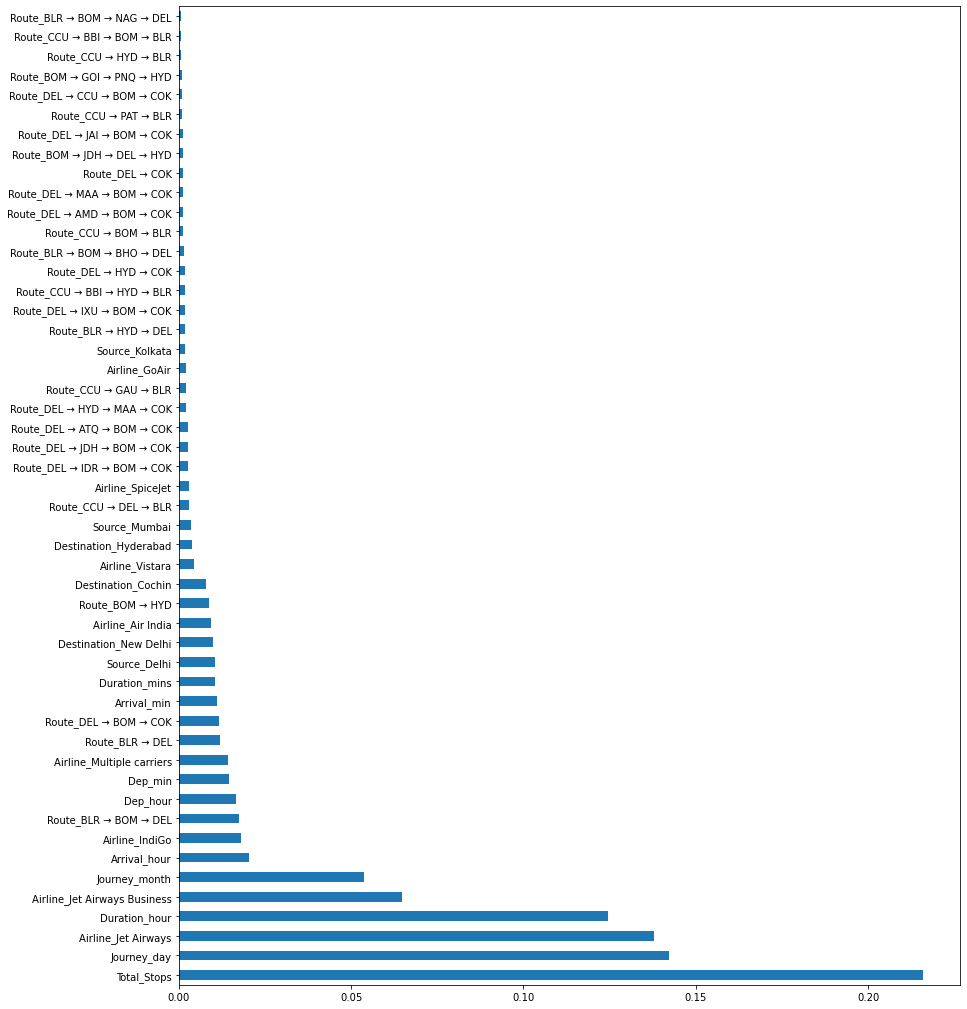

In [93]:
# plot graph for important features
plt.figure(figsize=(14,18))
feat_importances = pd.Series(selection.feature_importances_,index=X.columns)
feat_importances.nlargest(50).plot(kind="barh")
plt.show()

# Fitting Model using Random Forest

In [94]:
# splitting datset
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=0)

In [95]:
from sklearn.ensemble import RandomForestRegressor
reg_rf = RandomForestRegressor()
reg_rf.fit(X_train,y_train)

RandomForestRegressor()

In [96]:
y_pred=reg_rf.predict(X_test)

In [97]:
reg_rf.score(X_train,y_train)

0.955867408873461

In [98]:
reg_rf.score(X_test,y_test)

0.8161043386954772

C:\Users\acer\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


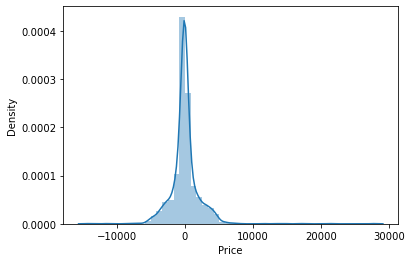

In [99]:
sns.distplot(y_test-y_pred)
plt.show()

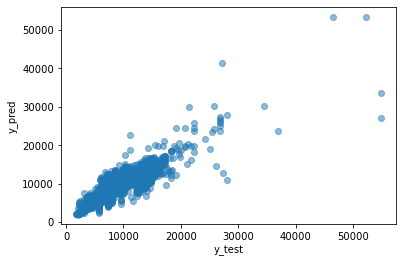

In [100]:
plt.scatter(y_test,y_pred,alpha=0.5)
plt.xlabel("y_test")
plt.ylabel("y_pred")
plt.show()

In [101]:
from sklearn import metrics
print("MAE",metrics.mean_absolute_error(y_test,y_pred))
print("MSE",metrics.mean_squared_error(y_test,y_pred))
print("RMSE",np.sqrt(metrics.mean_squared_error(y_test,y_pred)))

print("r2 score",metrics.r2_score(y_test,y_pred))

MAE 1209.4788092195463
MSE 4314776.077126459
RMSE 2077.203908413052
r2 score 0.8161043386954772


# HyperParameter Tuning

.choose following method for hyperparameter tuning
    1. RandomSearchCv -> Fats
    2. GridSearchCv
. Assign Hyperparameters in form of dictionary
.Fit the model


In [102]:
from sklearn.model_selection import RandomizedSearchCV

In [103]:
#Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start=100,stop=1200,num=12)]
# number of fetures to consider at every split
max_features = ['auto','sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(5,30,num=6)]
# Minimum number of samples required to split a node
min_samples_split =[2,5,10,15,100]
#Minimum number of samples required at each leaf node
min_samples_leaf = [1,2,5,10]

In [104]:
#Create random grid
random_grid = {'n_estimators':n_estimators,
              'max_features':max_features,
              'max_depth':max_depth,
              'min_samples_split':min_samples_split,
              'min_samples_leaf':min_samples_leaf}

In [105]:
rf_random=RandomizedSearchCV(estimator=reg_rf,param_distributions=random_grid,scoring = 'neg_mean_squared_error',n_iter=20,cv=5,verbose=2,random_state=0,n_jobs=1)

In [106]:
rf_random.fit(X_train,y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=900; total time=   4.9s
[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=900; total time=   5.2s
[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=900; total time=   5.1s
[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=900; total time=   5.1s
[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=900; total time=   5.0s
[CV] END max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=400; total time=   7.3s
[CV] END max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=400; total time=   7.5s
[CV] END max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_es

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_iter=20, n_jobs=1,
                   param_distributions={'max_depth': [5, 10, 15, 20, 25, 30],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 5, 10],
                                        'min_samples_split': [2, 5, 10, 15,
                                                              100],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500, 600, 700, 800,
                                                         900, 1000, 1100,
                                                         1200]},
                   random_state=0, scoring='neg_mean_squared_error', verbose=2)

In [107]:
rf_random.best_params_

{'n_estimators': 200,
 'min_samples_split': 5,
 'min_samples_leaf': 2,
 'max_features': 'auto',
 'max_depth': 15}

In [108]:
prediction = rf_random.predict(X_test)

C:\Users\acer\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


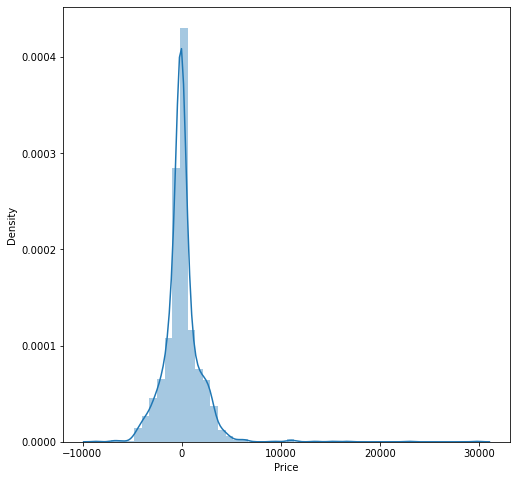

In [109]:
plt.figure(figsize=(8,8))
sns.distplot(y_test-prediction)
plt.show()

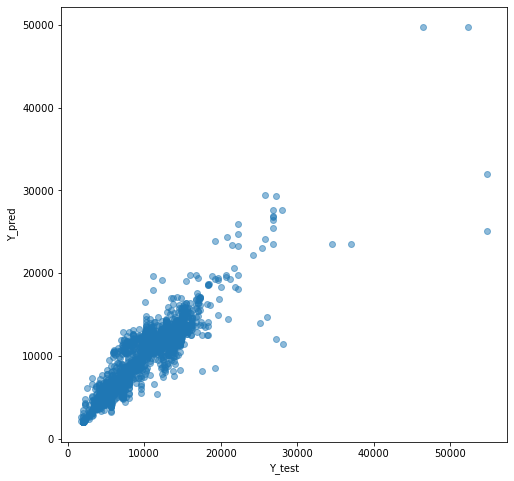

In [110]:
plt.figure(figsize=(8,8))
plt.scatter(y_test,prediction,alpha=0.5)
plt.xlabel("Y_test")
plt.ylabel("Y_pred")
plt.show()

# Save The Model To Use It Again

In [111]:
import pickle
#open a file, where you want to store the data
file = open("Flight_fare.pkl",'wb')
#dump information into that file
pickle.dump(reg_rf,file)

In [112]:
model = open("Flight_fare.pkl",'rb')
forest = pickle.load(model)

In [113]:
y_prediction = forest.predict(X_test)

In [114]:
print("MAE",metrics.mean_absolute_error(y_test,y_pred))
print("MSE",metrics.mean_squared_error(y_test,y_pred))
print("RMSE",np.sqrt(metrics.mean_squared_error(y_test,y_pred)))
metrics.r2_score(y_test,y_prediction)

MAE 1209.4788092195463
MSE 4314776.077126459
RMSE 2077.203908413052


0.8161043386954772